In [52]:
#########################
### Necessary imports ###
########################

# Reading and cleaning the data 
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import text_to_word_sequence 
from gensim.parsing.preprocessing import remove_stopword_tokens, remove_stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
import csv

# Embedding with Word2vec
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Deep Learning Models
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import regularizers 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping

# Visualization 
import matplotlib.pyplot as plt

# Loading the data set

In [53]:
#########################
### Loading the data ###
########################

#### Splits the data set
# creates 2 tuples for which the 1st index are the reviews and the 2nd are the classes 0 or 1
train_data, test_data = tfds.load(name="imdb_reviews", split=["train", "test"], batch_size=-1, as_supervised=True)

#### Converting a tf.data.Dataset to an iterable of NumPy arrays.
# we create arrays with the reviews and the classes by splitting the tuples above. 
# each index of the tuples will be [0] a review (sentences) or [1] a class (y)
train_sentences, y_train = tfds.as_numpy(train_data) 
test_sentences, y_test = tfds.as_numpy(test_data) 

## The next cells explain what was done when loading the data and why it was necessary due to different data types:

In [58]:
##### train_data and test_data are TUPLES, where the 1st index[0] are the reviews and the 2nd index [1] are the classes 0 or 1
type(train_data), type(test_data)

(tuple, tuple)

In [4]:
### Displaying the reviews of the training set (25.000): 
train_data[0]

<tf.Tensor: shape=(25000,), dtype=string, numpy=
array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fe

In [10]:
### Displaying the reviews of the testing set (25.000): 
test_data[0]

<tf.Tensor: shape=(25000,), dtype=string, numpy=
array([b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come.",


In [5]:
### Displaying the classes of the training set (25.000): 
train_data[1]

<tf.Tensor: shape=(25000,), dtype=int64, numpy=array([0, 0, 0, ..., 0, 0, 1])>

In [9]:
### Displaying the classes of the testing set (25.000): 
test_data[1]

<tf.Tensor: shape=(25000,), dtype=int64, numpy=array([1, 1, 0, ..., 0, 1, 1])>

In [7]:
##### train_sentences and test_sentences are ndarrays where each index is one review. Let's see the first ones: 
type(train_sentences), train_sentences[0]

(numpy.ndarray,
 b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.")

In [8]:
type(test_sentences), test_sentences[0]

(numpy.ndarray,
 b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come.")

In [11]:
##### y_train and y_test are ndarrays where each index is a class 0 (negative) or 1 (positive)
type(y_train), y_train[0]

(numpy.ndarray, 0)

In [12]:
type(y_test), y_test[0]

(numpy.ndarray, 1)

In [13]:
##### the python type of each index of the train_sentences ndarray is 'bytes'.
##### this is why Python bytes .decode() function was used to convert bytes to string object that can be manipulated.
type(train_sentences[0])

bytes

In [14]:
#### This is a very well balanced data set, with the same number os positive and negative reviews 
# (12.500 for each in both training and test sets)
np.unique(y_train, return_counts=True)

(array([0, 1]), array([12500, 12500]))

In [15]:
np.unique(y_test, return_counts=True)

(array([0, 1]), array([12500, 12500]))

# Cleaning the data set

In [66]:
#########################
### Cleaning the data ###
#########################

#### iterates through all the elements of sentences converting bytes to strings
# at the same time it removes stop words
X_train = [remove_stopwords(_.decode("utf-8")) for _ in train_sentences] 
X_test = [remove_stopwords(_.decode("utf-8")) for _ in test_sentences]

#### Stemming 
ps = PorterStemmer()
X_train = [ps.stem(_, to_lowercase=False) for _ in X_train]
X_test = [ps.stem(_, to_lowercase=False) for _ in X_test]

#### text_to_word_sequence() converts a text (strings) to a sequence of words (or tokens)
# it already has some parametres that clean the data as default (punctuation and sets all to lower case)

#### converting strings to lists of words. We will have a list of lists both for X_train and X_test.
# each list is one single review split into words (each word is an element of the list).
# for the main bigger list, each index will be, obviously, a list of words.
X_train = [text_to_word_sequence(_, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\b\r') for _ in X_train] 
X_test = [text_to_word_sequence(_, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\b\r') for _ in X_test]
  
X_train, y_train, X_test, y_test

([['this',
   'absolutely',
   'terrible',
   'movie',
   "don't",
   'lured',
   'christopher',
   'walken',
   'michael',
   'ironside',
   'both',
   'great',
   'actors',
   'simply',
   'worst',
   'role',
   'history',
   'even',
   'great',
   'acting',
   'redeem',
   "movie's",
   'ridiculous',
   'storyline',
   'this',
   'movie',
   'early',
   'nineties',
   'us',
   'propaganda',
   'piece',
   'the',
   'pathetic',
   'scenes',
   'columbian',
   'rebels',
   'making',
   'cases',
   'revolutions',
   'maria',
   'conchita',
   'alonso',
   'appeared',
   'phony',
   'pseudo',
   'love',
   'affair',
   'walken',
   'pathetic',
   'emotional',
   'plug',
   'movie',
   'devoid',
   'real',
   'meaning',
   'i',
   'disappointed',
   'movies',
   'like',
   'this',
   'ruining',
   "actor's",
   'like',
   'christopher',
   "walken's",
   'good',
   'name',
   'i',
   'barely',
   'sit',
   'it'],
  ['i',
   'known',
   'fall',
   'asleep',
   'films',
   'usually',
   'c

Text(0.5, 1.0, 'Wordcould Train set')

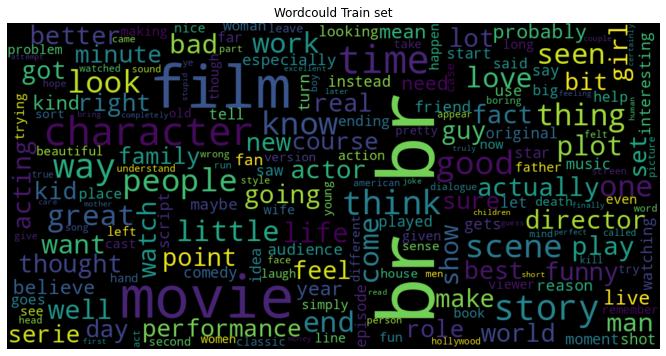

In [67]:
words = ' '.join(' '.join(word) for word in X_train)
word_cloud = WordCloud(width=1000, height=500, random_state=20, max_font_size=120).generate(words)

fig, ax = plt.subplots(figsize=(12,6))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcould Train set')

Text(0.5, 1.0, 'Wordcould Test set')

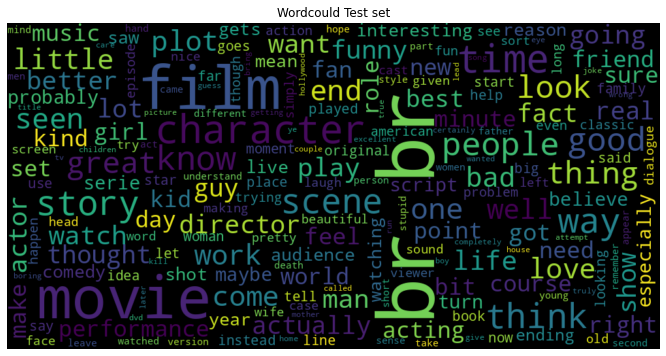

In [68]:
words = ' '.join(' '.join(word) for word in X_test)
word_cloud = WordCloud(width=1000, height=500, random_state=20, max_font_size=120).generate(words)

fig, ax = plt.subplots(figsize=(12,6))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcould Test set')

In [17]:
### creating a csv of the cleaned X_train
with open("X_train_clean.csv", "w") as f:
    wr = csv.writer(f)
    wr.writerows(X_train)

In [18]:
### creating a csv of the cleaned X_test
with open("X_test_clean.csv", "w") as f:
    wr = csv.writer(f)
    wr.writerows(X_test)

# Embedding with Word2Vec so each word becomes a vector in a vector space: 

This is a necessary step. Since computers are not scaled to have words as inputs, we need to convert words into numbers. Each word will become a vector so it can be fed to the Neural Network. 
To embed a word = represent it in a high dimensional space. 
In a good embedding, semantically close words are mathematically close in the vector space. 

In [19]:
### training a Word2Vec model on the training sentences and storing it into a variable word2vec

word2vec = Word2Vec(sentences=X_train, vector_size=60, min_count=10, window=10)

# Creating functions to make the data ready to feed the models

In [20]:
# Function to convert a sentence (list of words) into a matrix representing the words in the embedding space
def embed_sentence(word2vec, sentence):
    '''.wv gets numpy vector of a word, and the function adds it to a ndarray'''
    embedded_sentence = []
    for word in sentence:
        if word in word2vec.wv:
            embedded_sentence.append(word2vec.wv[word])
        
    return np.array(embedded_sentence)

# Function that converts a list of sentences into a list of matrices
def embedding(word2vec, sentences):
    '''uses the previously defined function and adds the arrays of vectors to a list'''
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence(word2vec, sentence)
        embed.append(embedded_sentence)
        
    return embed

# Embed the training and test sentences (applies word2vec model to out X)
X_train_embed = embedding(word2vec, X_train)
X_test_embed = embedding(word2vec, X_test)


# Pad the training and test embedded sentences: 
# as not all observations have the same lenght, padding is necessary to create a tensor
X_train_pad = pad_sequences(X_train_embed, dtype='float32', padding='post', maxlen=200)
X_test_pad = pad_sequences(X_test_embed, dtype='float32', padding='post', maxlen=200)

# A Baseline model

In [21]:
### Baseline model to assure our model predictions are better than random predictions depending on chance. 
### In this case, our baseline accuracy is the percentage of chance of finding the class that is most present in y_train,
### in a perfectly balanced dataset like ours, it is 50%. Our models should performs significantly better than this. 

np.unique(y_train, return_counts=True)

(array([0, 1]), array([12500, 12500]))

# RNN model

In [23]:
#  Kernel Regularization: an L2-regularizer with alpha = 0.01
reg_l2 = regularizers.L2(0.01)

def init_model_RNN():
    # model architecture
    model_RNN = Sequential()
    model_RNN.add(layers.Masking())
    model_RNN.add(layers.LSTM(30, activation='tanh', return_sequences=True, kernel_regularizer = reg_l2))
    model_RNN.add(layers.LSTM(30, activation='tanh', return_sequences=False))
    model_RNN.add(layers.Dense(15, activation='relu'))
    model_RNN.add(layers.Dropout(rate=0.4))
    model_RNN.add(layers.Dense(1, activation='sigmoid'))
    
    # model compile
    model_RNN.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    return model_RNN

model_RNN = init_model_RNN()


In [24]:
### Fitting the embedded and padded data to the RNN model 

es = EarlyStopping(patience=10, restore_best_weights=True)

history_RNN = model_RNN.fit(X_train_pad, y_train, 
                            batch_size = 32,
                            epochs=100,
                            validation_split=0.2,
                            callbacks=[es]
                           )

Epoch 1/100
625/625 [==============================] - 153s 236ms/step - loss: 0.6436 - accuracy: 0.8093 - val_loss: 0.4730 - val_accuracy: 0.8284
Epoch 2/100
625/625 [==============================] - 155s 248ms/step - loss: 0.4447 - accuracy: 0.8461 - val_loss: 0.4418 - val_accuracy: 0.8236
Epoch 3/100
625/625 [==============================] - 145s 232ms/step - loss: 0.4066 - accuracy: 0.8547 - val_loss: 0.3628 - val_accuracy: 0.8720
Epoch 4/100
625/625 [==============================] - 157s 251ms/step - loss: 0.3848 - accuracy: 0.8616 - val_loss: 0.3894 - val_accuracy: 0.8444
Epoch 5/100
625/625 [==============================] - 154s 246ms/step - loss: 0.3756 - accuracy: 0.8637 - val_loss: 0.3512 - val_accuracy: 0.8758
Epoch 6/100
625/625 [==============================] - 157s 251ms/step - loss: 0.3665 - accuracy: 0.8673 - val_loss: 0.3503 - val_accuracy: 0.8722
Epoch 7/100
625/625 [==============================] - 152s 244ms/step - loss: 0.3554 - accuracy: 0.8716 - val_loss: 0

In [25]:
# Model evaluation
res = model_RNN.evaluate(X_test_pad, y_test, verbose=1)

print(f'The accuracy evaluated on the test set is of {res[1]*100:.3f}%')

  3/782 [..............................] - ETA: 33s - loss: 0.4270 - accuracy: 0.7812

2022-09-09 03:34:25.080447: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1200000000 exceeds 10% of free system memory.


782/782 [==============================] - 40s 51ms/step - loss: nan - accuracy: 0.8720
The accuracy evaluated on the test set is of 87.204%


In [26]:
history_RNN_dict = history_RNN.history
history_RNN_dict.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

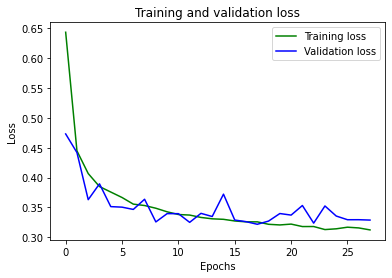

In [27]:
acc_rnn = history_RNN_dict['accuracy']
val_acc_rnn = history_RNN_dict['val_accuracy']
loss_rnn = history_RNN_dict['loss']
val_loss_rnn = history_RNN_dict['val_loss']

epochs = range(len(acc_rnn))

# "g" is for "solid green line"
plt.plot(epochs, loss_rnn, 'g', label='Training loss')

# b is for "solid blue line"
plt.plot(epochs, val_loss_rnn, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

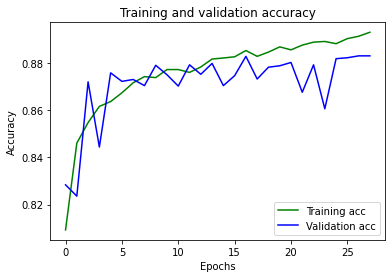

In [28]:
plt.plot(epochs, acc_rnn, 'g', label='Training acc')
plt.plot(epochs, val_acc_rnn, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

# CNN Model

In [11]:
# Kernel Regularization: an L2-regularizer with alpha = 0.01
reg_l2 = regularizers.L2(0.01)

def init_model_CNN():
    # model architecture
    model_CNN = Sequential()
    model_CNN.add(layers.Conv1D(filters=16, kernel_size=3, padding='same', activation='relu', kernel_regularizer = reg_l2))
    model_CNN.add(layers.MaxPooling1D(pool_size=2))
    model_CNN.add(layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', kernel_regularizer = reg_l2))
    model_CNN.add(layers.MaxPooling1D(pool_size=2))
    model_CNN.add(layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_regularizer = reg_l2))

    model_CNN.add(layers.Flatten())
    model_CNN.add(layers.Dropout(rate=0.4))
    model_CNN.add(layers.Dense(40,))
    model_CNN.add(layers.Dropout(rate=0.4))
    model_CNN.add(layers.Dense(1, activation='sigmoid'))
    

    # model compile
    
    # Instantiating the Adam optimizer starting with the initial learning rate 0.01
    initial_learning_rate = 0.01 
    
    # Implementing Exponential Decay to decrease this learning rate progressively as the network converges
    lr_schedule = ExponentialDecay(initial_learning_rate, 
                                   decay_steps = 2000, 
                                   decay_rate = 0.5)
    
    adam = Adam(learning_rate = lr_schedule)

    model_CNN.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model_CNN

model_CNN= init_model_CNN()

In [12]:
### Fitting the embedded and padded data to the CNN model 

es_cnn = EarlyStopping(patience=10, restore_best_weights=True)

history_CNN = model_CNN.fit(X_train_pad, y_train, 
                            epochs=100, 
                            batch_size=32,
                            validation_split=0.2,
                            callbacks=[es_cnn]
                           )

Epoch 1/100
625/625 [==============================] - 7s 10ms/step - loss: 1.0827 - accuracy: 0.7667 - val_loss: 0.5922 - val_accuracy: 0.8306
Epoch 2/100
625/625 [==============================] - 6s 9ms/step - loss: 0.6324 - accuracy: 0.8148 - val_loss: 0.5666 - val_accuracy: 0.8436
Epoch 3/100
625/625 [==============================] - 7s 11ms/step - loss: 0.6076 - accuracy: 0.8149 - val_loss: 0.6026 - val_accuracy: 0.8052
Epoch 4/100
625/625 [==============================] - 6s 10ms/step - loss: 0.5799 - accuracy: 0.8207 - val_loss: 0.5320 - val_accuracy: 0.8342
Epoch 5/100
625/625 [==============================] - 6s 10ms/step - loss: 0.5512 - accuracy: 0.8259 - val_loss: 0.5088 - val_accuracy: 0.8404
Epoch 6/100
625/625 [==============================] - 6s 10ms/step - loss: 0.5332 - accuracy: 0.8262 - val_loss: 0.5247 - val_accuracy: 0.8198
Epoch 7/100
625/625 [==============================] - 6s 10ms/step - loss: 0.5134 - accuracy: 0.8314 - val_loss: 0.4779 - val_accuracy: 

In [13]:
# Model evaluation
res_cnn = model_CNN.evaluate(X_test_pad, y_test, verbose=1)

print(f'The accuracy evaluated on the test set is of {res_cnn[1]*100:.3f}%')

 29/782 [>.............................] - ETA: 2s - loss: 0.4205 - accuracy: 0.8491

2022-09-08 21:27:02.527613: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1200000000 exceeds 10% of free system memory.


782/782 [==============================] - 3s 4ms/step - loss: 0.3889 - accuracy: 0.8587
The accuracy evaluated on the test set is of 85.868%


In [14]:
history_CNN_dict = history_CNN.history
history_CNN_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

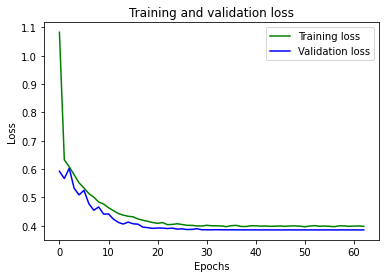

In [15]:
acc_cnn = history_CNN_dict['accuracy']
val_acc_cnn = history_CNN_dict['val_accuracy']
loss_cnn = history_CNN_dict['loss']
val_loss_cnn = history_CNN_dict['val_loss']

epochs = range(len(acc_cnn))

# "g" is for "solid green line"
plt.plot(epochs, loss_cnn, 'g', label='Training loss')

# b is for "solid blue line"
plt.plot(epochs, val_loss_cnn, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

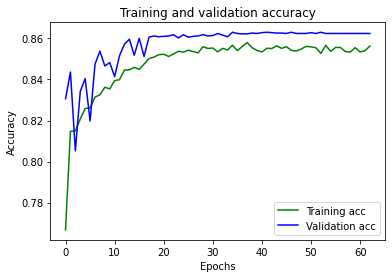

In [16]:
plt.plot(epochs, acc_cnn, 'g', label='Training acc')
plt.plot(epochs, val_acc_cnn, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()